In [13]:
from typing import Any, Callable, List, Optional, Tuple, Dict
import json, sys
import numpy as np
import pandas as pd
import citylearn
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv
from utils.env_utils import keep_only_core_observations, keep_only_electrical_storage

print('Python:', sys.version.split()[0])
print('CityLearn:', citylearn.__version__)

Python: 3.11.7
CityLearn: 2.4.1


In [14]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1'  # adjust if needed
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['100%_discharge','50%_discharge','idle','50%_charge','100%_charge']
NAME_TO_FRAC = {
    '100%_discharge': -1.0,
    '50%_discharge': -0.5,
    'idle': 0.0,
    '50%_charge': 0.5,
    '100%_charge': 1.0,
}

In [15]:
class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str], # ['soc', 'price', 'net_load', 'solar_generation']
                    action_space: List[str], # ['charge', 'discharge', 'idle'] 
                    rule_defs: List[Dict] = None, 
                    # e.g. [
                    #   {
                    #     "conditions": [
                    #       {"field":"soc","op":"<","threshold_name":"soc_low"}
                    #     ],
                    #     "action":"charge"
                    #   }
                    # ]
                    thresholds: Dict[str, float] = None, # {'soc': 0.2, 'price': 50.0}
                    history: List[Tuple[Dict[str, float], str, float]] = None, # [(observation_dict, action_str, reward_float)]
                    obs_index_map: Optional[Dict[str, int]] = None):   # <--- NEW (optional)
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        self.obs_index_map = obs_index_map or {}                   # <--- NEW

        # Initialize rules from dictionaries
        self.rules = [(self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs]

    def set_obs_index_map(self, mapping: Dict[str, int]):          
        self.obs_index_map = dict(mapping)

    def _ensure_obs_map(self, env):                                 
        if self.obs_index_map:
            return
        names = getattr(env.buildings[0], "active_observations", None)
        if not names:
            raise RuntimeError(
                "obs_index_map missing and env has no observation_names. "
                "Call agent.set_obs_index_map({'soc': i, 'price': j, 'net_load': k, 'solar_generation': m})."
            )
        name_to_idx = {n: i for i, n in enumerate(names)}
        # default aliases
        wanted = {
            "soc": "electrical_storage_soc",
            "price": "electricity_pricing",
            "net_load": "net_electricity_consumption",  # or 'non_shiftable_load'
            "solar_generation": "solar_generation",
        }
        try:
            self.obs_index_map = {k: name_to_idx[wanted[k]] for k in self.obs_keys}
        except KeyError as e:
            raise RuntimeError(
                f"Could not auto-map {e}. "
                f"Available names include: {names[:20]} ..."
            )
    
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        # Rebuild rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    
    def evaluate(self, env, broadcast=False,  max_steps=None) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        self._ensure_obs_map(env)
        episode_history = []
        episode_reward = 0.0
        steps = 0


        done = False
        while not done and (max_steps is None or steps < max_steps):
            # 1) Observations for all buildings -> take building 0 only
            obs_all = env.observations            # List[List[float]]
            obs_vec  = obs_all[0]                         # features of building 0
            #obs_dict = {k: float(b0[i]) for i, k in enumerate(self.obs_keys)}
            obs_dict = {k: float(obs_vec [self.obs_index_map[k]]) for k in self.obs_keys}

            b0 = env.buildings[0]
            ts = b0.time_step
            obs_soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
            obs_dict['soc'] = float(obs_soc)

            # 2) Decide action for building 0
            action = self.act(obs_dict)

            # map the string action to numeric fractions for each storage
            # charge → +1.0, idle → 0.0, discharge → -1.0
            frac_map = { 
                '100%_charge': 1.0, 
                '50%_charge': 0.5, 
                'idle': 0.0, 
                '50%_discharge': -0.5, 
                '100%_discharge': -1.0 } 
            frac = frac_map[action]
            
            # 3) Build central-agent action list: control b0, zeros elsewhere
            N = env.action_space[0].shape[0]

            if broadcast:
                actions = [[float(np.clip(frac, -1.0, 1.0))] * N]
            else:
                flat = [0.0] * N
                flat[0] = float(np.clip(frac, -1.0, 1.0))
                actions = [flat]

            # 4) Step the env and unpack
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)

            # 5) Use only building 0's reward
            step_reward = float(reward_list[0])

            # 6) Log + accumulate
            #print(f"{obs_dict}, {action}, {step_reward}")
            episode_history.append((obs_dict, action, step_reward))
            self.history.append((obs_dict, action, step_reward))

            episode_reward += step_reward
            done = bool(terminated) or bool(truncated)

            steps += 1

        return episode_reward, episode_history
    
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        self.histories = []
        for _ in range(episodes):
            print(f"Episode {_ + 1}/{episodes}")
            episode_reward, episode_history = self.evaluate(env)
            self.rewards.append(episode_reward)
            self.histories.append(episode_history)
        return self.rewards, self.histories

In [16]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)  # Load schema for the dataset
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN # Set reward function

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

schema = keep_only_electrical_storage(schema) # (fixes "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, extra_keep=['carbon_intensity'], drop_predictions=False)

five_level_actions = ['100%_charge', '50%_charge', 'idle', '50%_discharge', '100%_discharge']
five_level_rules=[
    # 100% charge: soc <= 0.20    
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_empty'}], 
        'action':'100%_charge'},
    # 50% charge: 0.20 < soc <= 0.30    
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_empty'}, 
        {'field':'soc','op':'<=','threshold_name':'soc_low'}], 
        'action':'50%_charge'},


    # 100% discharge: soc > 0.80 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_high'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'100%_discharge'},
    # 50% discharge: soc > 0.80 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_high'},
        {'field':'price','op':'<=','threshold_name':'price'}], 
        'action':'50%_discharge'},


    # 50% charge: soc <= 0.55 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_mid'},
        {'field':'price','op':'<=','threshold_name':'price'}], 
        'action':'50%_charge'},
    # idle: soc <= 0.55 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'<=','threshold_name':'soc_mid'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'idle'},

    # 50% discharge: soc > 0.55 and price > 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_mid'},
        {'field':'price','op':'>','threshold_name':'price'}], 
        'action':'50%_discharge'},
    # idle: soc > 0.55 and price <= 0.04
    {'conditions': [
        {'field':'soc','op':'>','threshold_name':'soc_mid'},
        {'field':'price','op':'<=','threshold_name':'price'}],  
        'action':'idle'},
]
thresholds={
    'soc_empty': 0.2, 
    'soc_low': 0.3,
    'soc_mid': 0.55, 
    'soc_high': 0.8, 
    'price': 0.04, 
}
env = CityLearnEnv(schema, central_agent=True)
agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=five_level_actions,
                 rule_defs=five_level_rules,
                 thresholds=thresholds,
                 history=[])


"""
0: day_type
1: hour
2: outdoor_dry_bulb_temperature
3: outdoor_dry_bulb_temperature_predicted_1
4: outdoor_dry_bulb_temperature_predicted_2
5: outdoor_dry_bulb_temperature_predicted_3
6: diffuse_solar_irradiance
7: diffuse_solar_irradiance_predicted_1
8: diffuse_solar_irradiance_predicted_2
9: diffuse_solar_irradiance_predicted_3
10: direct_solar_irradiance
11: direct_solar_irradiance_predicted_1
12: direct_solar_irradiance_predicted_2
13: direct_solar_irradiance_predicted_3
14: carbon_intensity
15: indoor_dry_bulb_temperature
16: non_shiftable_load
17: solar_generation
18: dwh_storage_soc
19: electrical_storage_soc
20: net_electricity_consumption
21: electricity_pricing
22: electricity_pricing_predicted_1
23: electricity_pricing_predicted_2
24: electricity_pricing_predicted_3
25: cooling demand
26: dwh demand
27: occupant count
28: power_outage
29: indoor_dry_bulb_temperature_cooling_set_point
"""

# evaluate 1 episode
r, hist = agent.evaluate(env, max_steps=1000)  # max steps while debugging

#rewards, histories = agent.multiple_evaluation(env, episodes=30)  

# build logs from 'hist', not agent.history
logs = [{'timestep': t, **obs, 'action': action, 'reward': reward} for t, (obs, action, reward) in enumerate(hist)]
df = pd.DataFrame(logs, columns=['timestep','soc','price','net_load','solar_generation','action','reward'])
df.to_csv('rbc_agent_logs.csv', index=False)

# Debug
print(f"Episode has {len(hist)} timesteps.")
print('Reward function:', type(env.reward_function).__name__)
print(env.schema['buildings'][env.buildings[0].name]['pricing'])

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-26_14-24-40'
Episode has 1000 timesteps.
Reward function: CostReward
pricing_germany_2023_june_to_august.csv


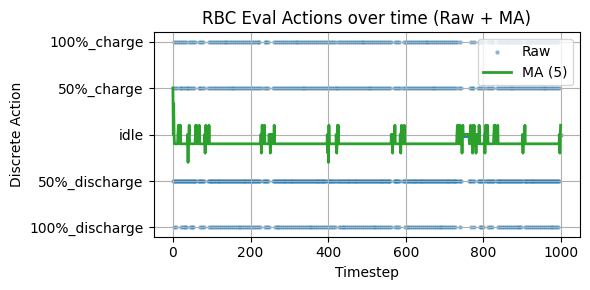

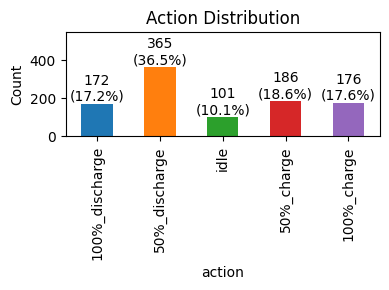

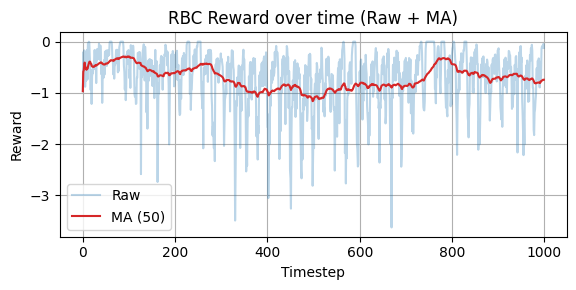

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.plotting_utils import timesteps_to_days

# Attempt to load the log data, handle if file is missing
try:
    df = pd.read_csv('rbc_agent_logs.csv')
except FileNotFoundError:
    print("Log file 'rbc_agent_logs.csv' not found.")

ep_logs = []
for t, (obs, act, rew) in enumerate(hist): # hist: List[(obs_dict, action_str, reward_float)]
    row = {'t': t, 'action': act, 'reward': rew}
    for k in ('soc','price','net_load','solar_generation'):
        if k in obs:
            row[k] = obs[k]
    ep_logs.append(row)
df = pd.DataFrame(ep_logs)

# ----- Plot 1: RBC Eval Actions over time (Raw + MA) -----
window = 5
df['action_num'] = df['action'].map(NAME_TO_FRAC)
df['action_ma'] = df['action_num'].rolling(window, min_periods=1).mean()
plt.figure(figsize=(6,3))
plt.scatter(df['t'], df['action_num'], s=5, alpha=0.4, label='Raw')
plt.plot(
    df['t'], 
    df['action_ma'], 
    color='C2', lw=2,
    label=f"MA ({window})"
)
plt.xlabel('Timestep'); 
#df = timesteps_to_days(df)
plt.title(f"RBC Eval Actions over time (Raw + MA)")
plt.yticks([-1.0,-0.5,0.0,0.5,1.0], ACTION_LABELS)
plt.ylabel('Discrete Action'); plt.legend(loc="upper right"); plt.grid(True); plt.tight_layout(); plt.show()


# ----- Plot 2: Action Distribution -----
plt.figure(figsize=(4,3))
counts = df['action'].value_counts().reindex(ACTION_LABELS).fillna(0)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()


# ----- Plot 3: MA vs. Raw Reward over Time -----
rw_window = 50
df['reward_ma'] = df['reward'].rolling(rw_window, min_periods=1).mean()
plt.figure(figsize=(6,3))
plt.plot(df['t'], df['reward'], alpha=0.3, label='Raw')
plt.plot(df['t'], df['reward_ma'], color='C3', label=f'MA ({rw_window})')
plt.xlabel('Timestep'); 
#df = timesteps_to_days(df)
plt.ylabel('Reward')
plt.title(f'RBC Reward over time (Raw + MA)')
plt.grid(True); plt.legend(loc="lower left"); plt.tight_layout(); plt.show()